In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from scipy import stats

In [3]:
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

## Linear Classification

[Text(0.5, 0, 'z'), Text(0, 0.5, 'logistic(z)')]

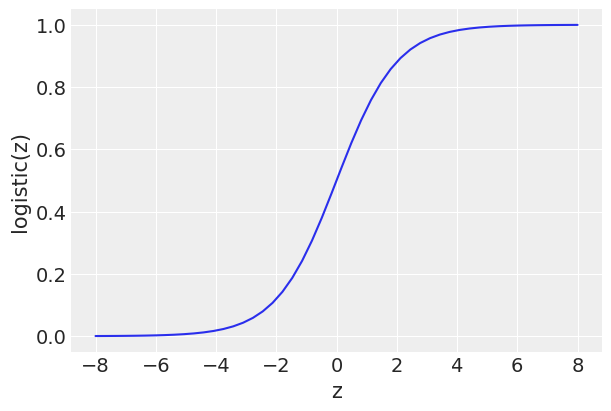

In [4]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

z = np.linspace(-8, 8)

ax.plot(z, 1 / (1 + np.exp(-z)))
ax.set(xlabel='z', ylabel='logistic(z)')
# plt.savefig('images/ch6/logistic.png')

## Logistic regression

In [5]:
iris = sns.load_dataset('iris')
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

<AxesSubplot:xlabel='species', ylabel='sepal_length'>

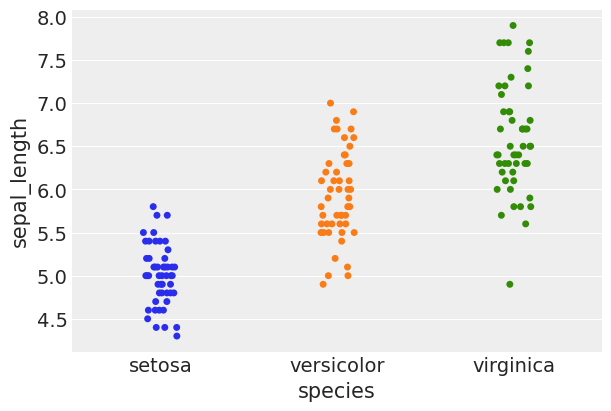

In [6]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True, ax=ax)
# plt.savefig('images/ch6/iris_stripplot.png')

In [7]:
plt.Figure(figsize=(6, 4))

# sns.pairplot(iris, hue='species', diag_kind='kde')

<Figure size 600x400 with 0 Axes>

### The logistic model applied to the iris dataset

In [8]:
df = iris.query("species == ('setosa', 'versicolor')")
x_0 = df['sepal_length'].values
x_c = x_0 - x_0.mean()
y_0 = pd.Categorical(df['species']).codes

In [9]:
with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)

    μ = α + pm.math.dot(x_c, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)

    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    # trace_0 = pm.sample(1000, return_inferencedata=True)
    # trace_0.to_netcdf("data/ch6/iris_log.nc")
    trace_0 = az.from_netcdf("../../data-pymc/ch6/iris_log.nc")

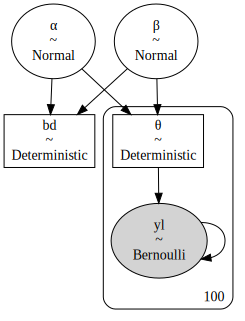

In [10]:
pm.model_to_graphviz(model_0)

In [11]:
az.summary(trace_0, var_names=['α', 'β', 'bd'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.316  0.339  -0.276    0.974      0.009    0.007    1301.0    1232.0   
β   5.435  1.073   3.494    7.386      0.030    0.022    1393.0    1290.0   
bd -0.057  0.062  -0.179    0.050      0.002    0.001    1416.0    1390.0   

    r_hat  
α     1.0  
β     1.0  
bd    1.0

In [12]:
# az.summary(trace_0, var_names=['α', 'β', 'bd']).to_markdown()

'|    |   mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_bulk |   ess_tail |   r_hat |\n|:---|-------:|------:|---------:|----------:|------------:|----------:|-----------:|-----------:|--------:|\n| α  |  0.316 | 0.339 |   -0.276 |     0.974 |       0.009 |     0.007 |       1301 |       1232 |       1 |\n| β  |  5.435 | 1.073 |    3.494 |     7.386 |       0.03  |     0.022 |       1393 |       1290 |       1 |\n| bd | -0.057 | 0.062 |   -0.179 |     0.05  |       0.002 |     0.001 |       1416 |       1390 |       1 |'

In [13]:
az.hdi(bd.mean(axis=0).values)

ValueError: Not enough dimensions on bd to reduce on axis 0

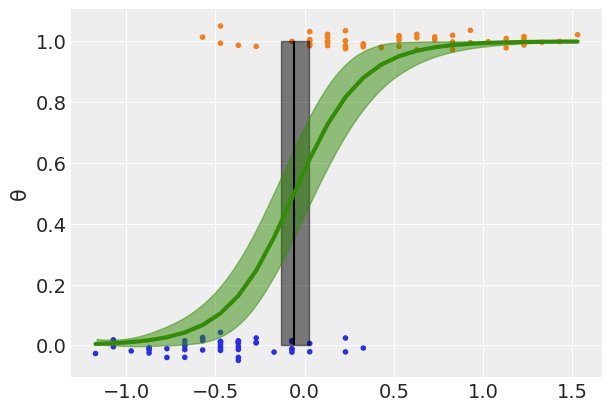

In [ ]:
θ = trace_0.posterior['θ'].mean(axis=0).mean(axis=0)
bd = trace_0.posterior['bd'].mean(axis=0)
idx = np.argsort(x_c)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.scatter(x_c,
           np.random.normal(y_0, 0.02),
           marker='.',
           color=[f'C{x}' for x in y_0])
ax.plot(x_c[idx], θ[idx], color='C2', lw=3)
ax.vlines(bd.mean(axis=0), 0, 1, color='k')

bd_hdi = az.hdi(bd.values)
ax.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)
az.plot_hdi(x_c, trace_0.posterior['θ'], color='C2', ax=ax)

ax.set(ylabel='θ')
# plt.savefig('images/ch6/iris_fit.png')


## Multiple logistic regression

In [ ]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values

In [ ]:
with pm.Model() as model_1:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n))

    μ = α + pm.math.dot(x_1, β)
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])

    yl = pm.Bernoulli('yl', p=θ, observed=y_1)

    # trace_1 = pm.sample(2000, return_inferencedata=True)
    # trace_1.to_netcdf("data/ch6/iris_mlog.nc")
    trace_1 = az.from_netcdf("../../data-pymc/ch6/iris_mlog.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 52 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


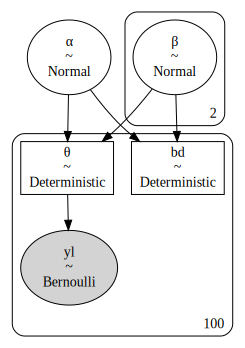

In [ ]:
pm.model_to_graphviz(model_1)

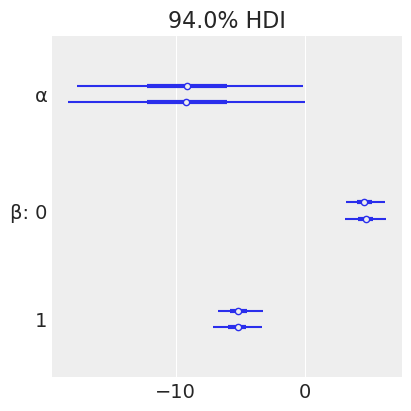

In [ ]:
_, ax = plt.subplots(figsize=(4, 4), dpi=100)

az.plot_forest(trace_1, var_names=['α', 'β'], ax=ax)
# plt.savefig('images/ch6/iris_mlog_forest.png')

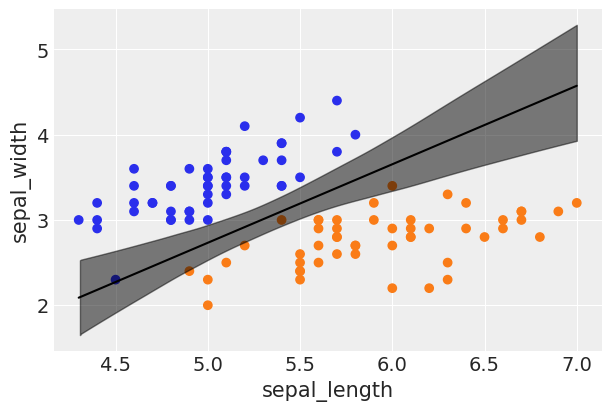

In [ ]:
idx = np.argsort(x_1[:, 0])
bd = trace_1.posterior['bd']

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.scatter(x_1[:, 0], x_1[:, 1], c=[f'C{x}' for x in y_0])
ax.plot(x_1[:, 0][idx], bd.mean(axis=0).mean(axis=0)[idx], color='k')

az.plot_hdi(x_1[:, 0], bd, color='k', ax=ax)
ax.set(xlabel=x_n[0], ylabel=x_n[1])
# plt.savefig('images/ch6/iris_mlog_bound.png')

### Interpreting the coefficients

/var/folders/93/795zm8c93m16_92qkk86t0_r0000gn/T/ipykernel_50386/3475749879.py:2: RuntimeWarning: divide by zero encountered in true_divide
  odds = probability / (1 - probability)


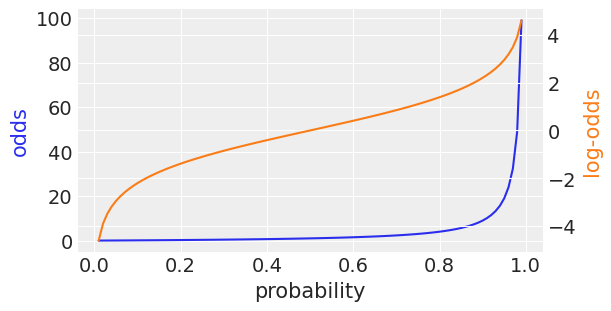

In [ ]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax = plt.subplots(figsize=(6, 3), dpi=100)

ax2 = ax.twinx()
ax.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax.set_xlabel('probability')
ax.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
# plt.savefig('images/ch6/odds.png')

In [ ]:
df = az.summary(trace_1, var_names=['α', 'β'])
df

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α    -9.036  4.720 -17.532    0.360      0.139    0.098    1170.0     953.0   
β[0]  4.670  0.846   3.147    6.256      0.026    0.019    1038.0    1158.0   
β[1] -5.220  1.001  -6.925   -3.266      0.029    0.020    1214.0    1087.0   

      r_hat  
α       1.0  
β[0]    1.0  
β[1]    1.0

In [ ]:
az.summary(trace_1, var_names=['α', 'β']).to_markdown()

'|      |   mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_bulk |   ess_tail |   r_hat |\n|:-----|-------:|------:|---------:|----------:|------------:|----------:|-----------:|-----------:|--------:|\n| α    | -9.036 | 4.72  |  -17.532 |     0.36  |       0.139 |     0.098 |       1170 |        953 |       1 |\n| β[0] |  4.67  | 0.846 |    3.147 |     6.256 |       0.026 |     0.019 |       1038 |       1158 |       1 |\n| β[1] | -5.22  | 1.001 |   -6.925 |    -3.266 |       0.029 |     0.02  |       1214 |       1087 |       1 |'

In [ ]:
from scipy.special import expit as logistic

In [ ]:
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)


log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

log_odds_versicolor_f - log_odds_versicolor_i, probability_versicolor_f - probability_versicolor_i

(4.67, 0.7043119157238346)

### Correlated variables

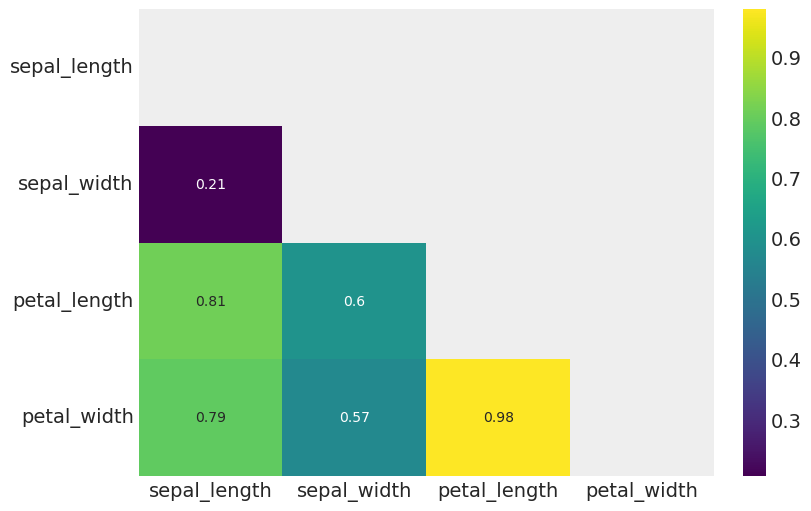

In [ ]:
corr = iris.query("species != 'virginica'").corr()

_, ax = plt.subplots(figsize=(8, 5), dpi=100)

mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis', ax=ax)
# plt.savefig('images/ch6/iris_mlog_corr.png')

### Unbalanced classes

In [ ]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_3 = df[x_n].values

In [ ]:
with pm.Model() as model_3:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n))

    μ = α + pm.math.dot(x_3, β)
    θ = 1 / (1 + pm.math.exp(-μ))
    bd = pm.Deterministic('bd', -α / β[1] - β[0] / β[1] * x_3[:, 0])

    yl = pm.Bernoulli('yl', p=θ, observed=y_3)

    # trace_3 = pm.sample(1000, return_inferencedata=True)
    # trace_3.to_netcdf("data/ch6/iris_mlog_unb.nc")
    trace_3 = az.from_netcdf("../../data-pymc/ch6/iris_mlog_unb.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


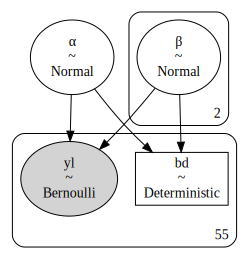

In [ ]:
pm.model_to_graphviz(model_3)

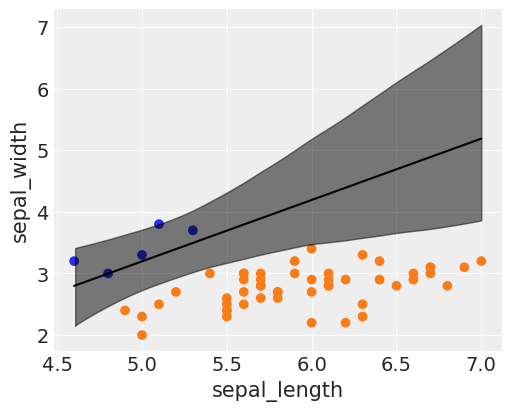

In [ ]:
idx = np.argsort(x_3[:, 0])
bd = trace_3.posterior['bd']

_, ax = plt.subplots(figsize=(5, 4), dpi=100)

ax.scatter(x_3[:, 0], x_3[:, 1], c=[f'C{x}' for x in y_3])
ax.plot(x_3[:, 0][idx], bd.mean(axis=0).mean(axis=0)[idx], color='k')
az.plot_hdi(x_3[:, 0], trace_3.posterior['bd'], color='k')

ax.set(xlabel=x_n[0], ylabel=x_n[1])
# plt.savefig('images/ch6/iris_mlog_unb.png')

## Softmax regression

In [ ]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [ ]:
import theano.tensor as tt

In [ ]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)
    β = pm.Normal('β', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    # trace_s = pm.sample(2000, return_inferencedata=True)
    # trace_s.to_netcdf("data/ch6/iris_sm.nc")
    trace_s = az.from_netcdf("../../data-pymc/ch6/iris_sm.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 115 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


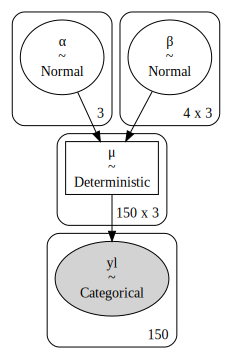

In [ ]:
pm.model_to_graphviz(model_s)

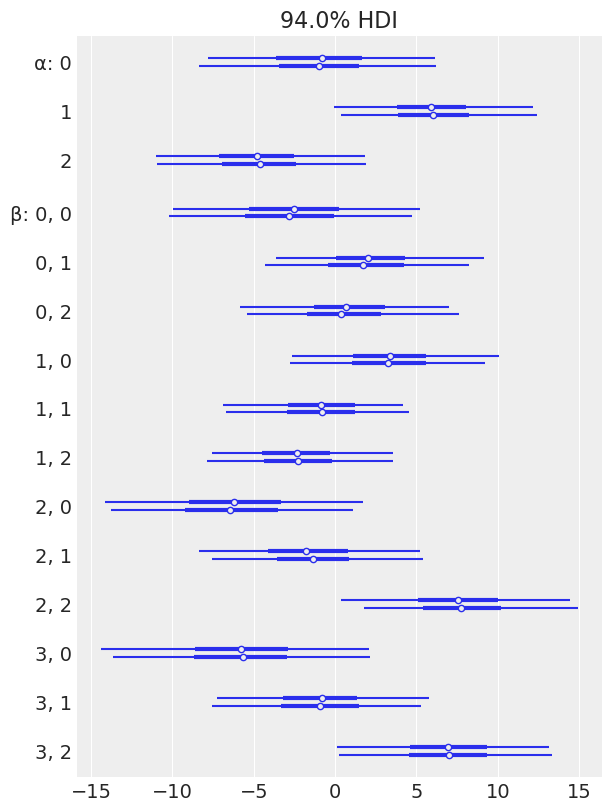

In [ ]:
_, ax = plt.subplots(figsize=(6, 8), dpi=100)

az.plot_forest(trace_s, var_names=['α', 'β'], ax=ax)
# plt.savefig('images/ch6/iris_sm_forest.png')

In [ ]:
data_pred = trace_s.posterior['μ'].mean(axis=0).mean(axis=0)

y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_pred]

f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

'0.98'

In [ ]:
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0, sd=2, shape=2)
    β = pm.Normal('β', mu=0, sd=2, shape=(4, 2))
    α_f = tt.concatenate([[0], α])
    β_f = tt.concatenate([np.zeros((4, 1)), β], axis=1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_sf = pm.sample(1000, return_inferencedata=True)
    trace_sf.to_netcdf("data/ch6/iris_sm2.nc")
    # trace_sf = az.from_netcdf("../../data-pymc/ch6/iris_sm2.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 54 seconds.


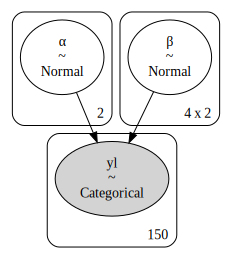

In [ ]:
pm.model_to_graphviz(model_sf)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

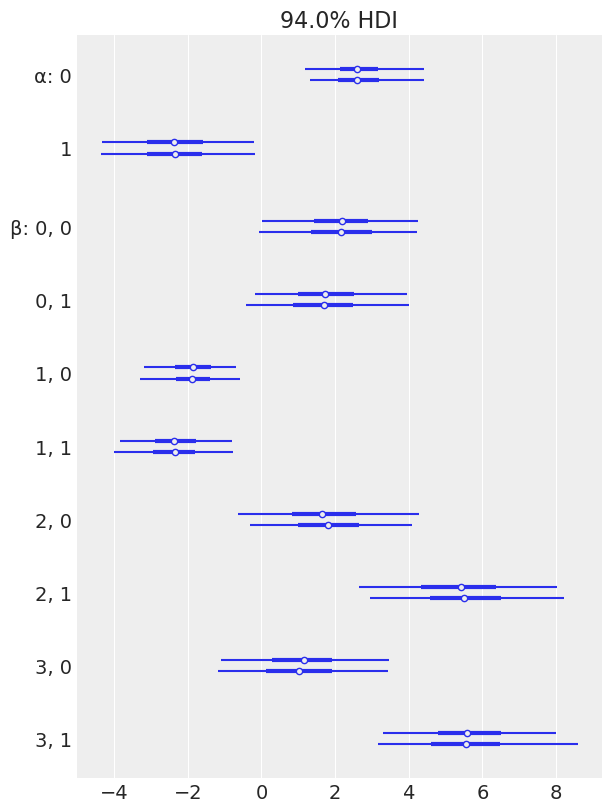

In [ ]:
_, ax = plt.subplots(figsize=(6, 8), dpi=100)

az.plot_forest(trace_sf, var_names=['α', 'β'], ax=ax)
# plt.savefig('images/ch6/iris_sm_forest2.png')

In [ ]:
trace_sf.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 1000, α_dim_0: 2, β_dim_0: 4, β_dim_1: 2)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * α_dim_0  (α_dim_0) int64 0 1
  * β_dim_0  (β_dim_0) int64 0 1 2 3
  * β_dim_1  (β_dim_1) int64 0 1
Data variables:
    α        (chain, draw, α_dim_0) float64 3.559 -1.549 2.143 ... 1.65 -3.772
    β        (chain, draw, β_dim_0, β_dim_1) float64 2.007 1.083 ... 3.049 6.322
Attributes:
    created_at:                 2021-08-18T08:20:21.346686
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              54.38529109954834
    tuning_steps:               1000

## Robust logistic regression

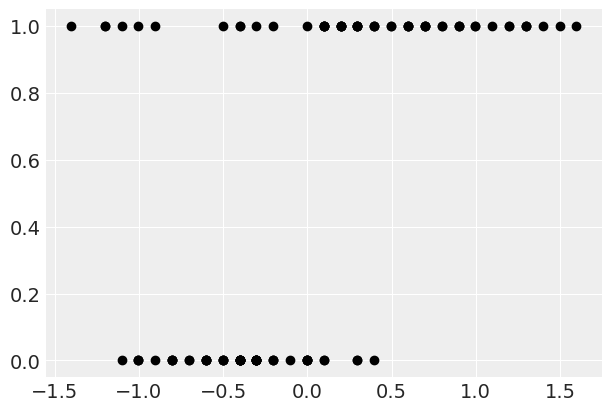

In [ ]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(6, dtype=int)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_c = x_0 - x_0.mean()

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.plot(x_c, y_0, 'o', color='k')
# plt.savefig('images/ch6/iris_intruded.png')

In [ ]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)

    μ = α + x_c *  β
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)

    π = pm.Beta('π', 1., 1.)
    p = π * 0.5 + (1 - π) * θ

    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    # trace_rlg = pm.sample(1000, return_inferencedata=True)
    # trace_rlg.to_netcdf("data/ch6/iris_rlog.nc")
    trace_rlg = az.from_netcdf("../../data-pymc/ch6/iris_rlog.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [π, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


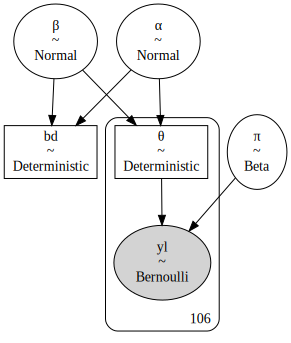

In [ ]:
pm.model_to_graphviz(model_rlg)

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>]], dtype=object)

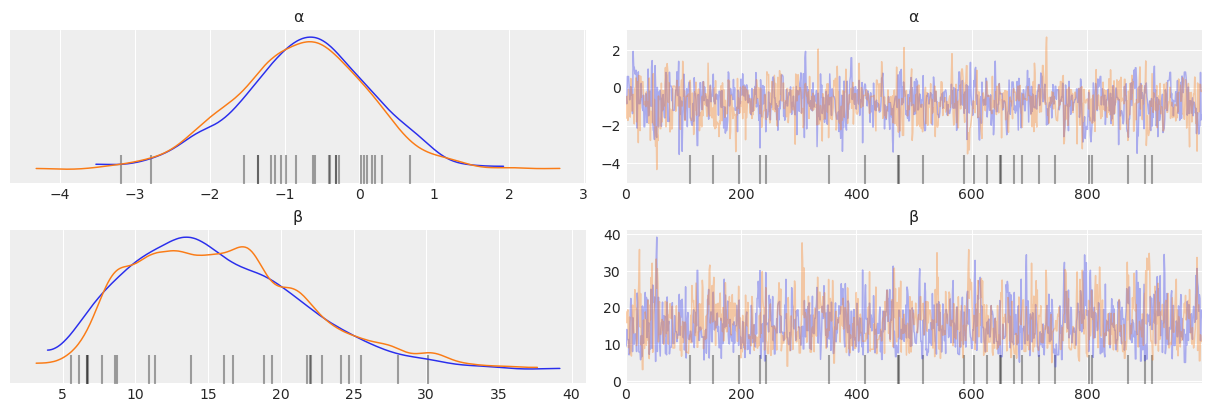

In [ ]:
az.plot_trace(trace_rlg, var_names=['α', 'β'], compact=False)

In [ ]:
az.summary(trace_rlg, var_names=['α', 'β', 'bd'])

mean    sd  mc error  hpd 3%  hpd 97%   eff_n  r_hat
α   -0.78  0.90      0.04   -2.46     0.94   980.0    1.0
β   15.77  6.36      0.26    5.65    27.70   821.0    1.0
bd   0.05  0.06      0.00   -0.05     0.17  1191.0    1.0

In [ ]:
az.summary(trace_rlg, var_names=['α', 'β', 'bd']).to_markdown()

'|    |   mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_bulk |   ess_tail |   r_hat |\n|:---|-------:|------:|---------:|----------:|------------:|----------:|-----------:|-----------:|--------:|\n| α  | -0.757 | 0.892 |   -2.449 |     0.858 |       0.029 |     0.021 |        977 |        955 |       1 |\n| β  | 15.699 | 5.947 |    5.448 |    26.556 |       0.207 |     0.148 |        837 |        939 |       1 |\n| bd |  0.046 | 0.058 |   -0.061 |     0.16  |       0.002 |     0.001 |       1306 |        970 |       1 |'

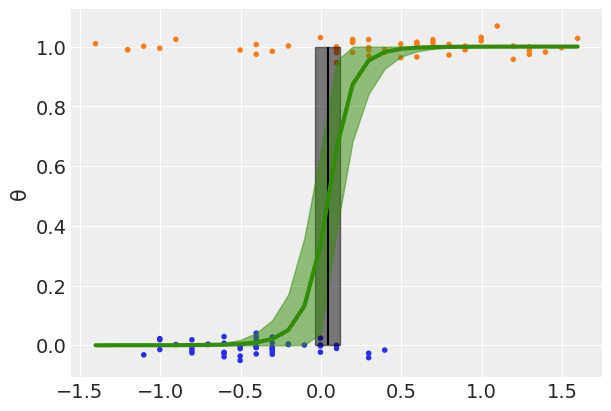

In [ ]:
θ = trace_rlg.posterior['θ']
bd = trace_rlg.posterior['bd'].mean(axis=0)
idx = np.argsort(x_c)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.scatter(x_c,
           np.random.normal(y_0, 0.02),
           marker='.',
           color=[f'C{x}' for x in y_0])
ax.plot(x_c[idx], θ.mean(axis=0).mean(axis=0)[idx], color='C2', lw=3)
ax.vlines(bd.mean(axis=0), 0, 1, color='k')

bd_hpd = az.hdi(bd.values)
ax.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
θ_hpd = az.hdi(θ.values)[idx]
ax.fill_between(x_c[idx], θ_hpd[:, 0], θ_hpd[:, 1], color='C2', alpha=0.5)

ax.set(ylabel='θ')
# plt.savefig('images/ch6/iris_rlog_bound.png')

## Possoin regression

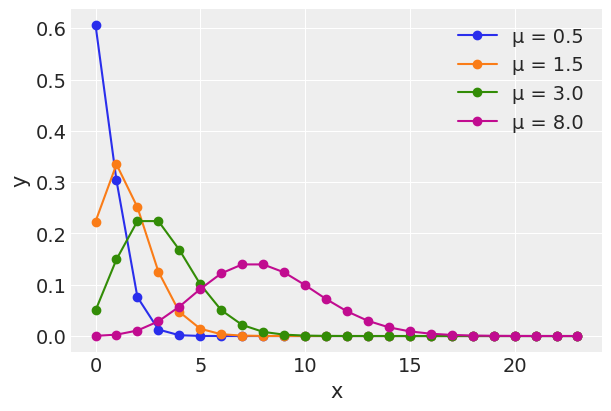

In [ ]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')

ax.set(xlabel='x', ylabel='y')
ax.legend()

### The Zero-Inflated Poisson model

In [ ]:
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) * 
                   np.random.poisson(θ_real) for i in range(n)])

In [ ]:
counts

array([1, 0, 0, 0, 0, 0, 0, 0, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0])

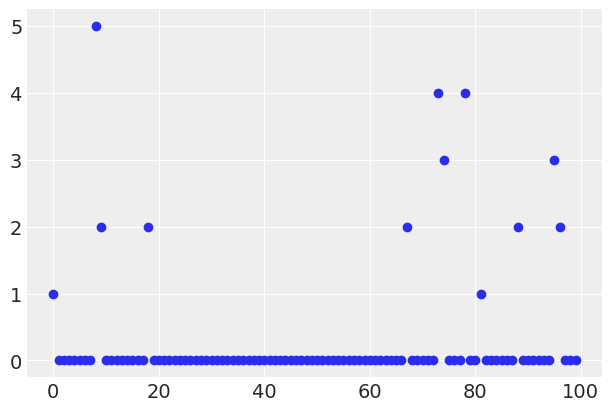

In [ ]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.plot(counts, 'o')

In [ ]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1, 1)
    θ = pm.Gamma('θ', 2, 0.1)
    y = pm.ZeroInflatedPoisson('y', ψ, θ,
                               observed=counts)
    # trace = pm.sample(1000, return_inferencedata=True)
    # trace.to_netcdf("data/ch6/zip.nc")
    trace = az.from_netcdf("../../data-pymc/ch6/zip.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, ψ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.


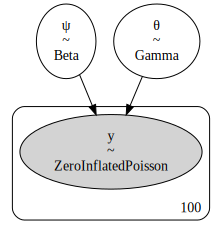

In [ ]:
pm.model_to_graphviz(ZIP)

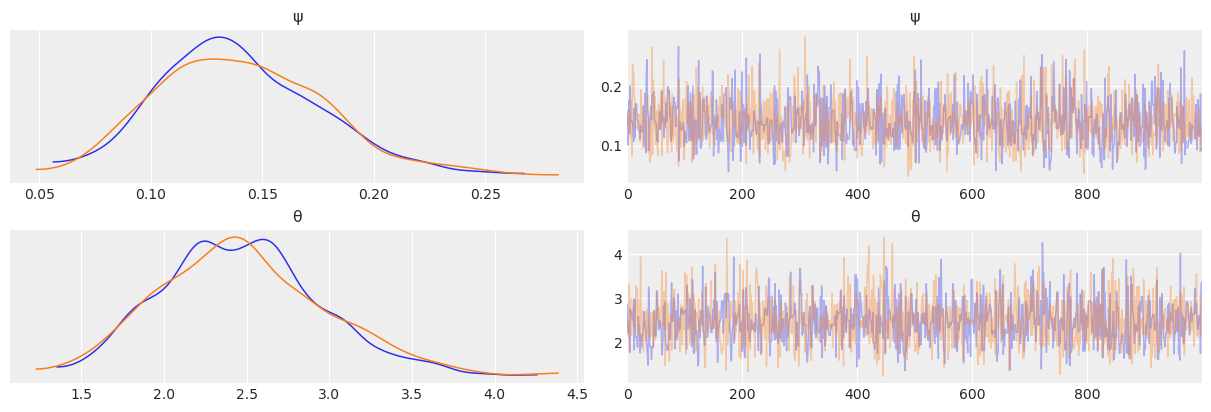

In [ ]:
az.plot_trace(trace, compact=False);

In [ ]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
ψ  0.140  0.037   0.071    0.208      0.001    0.001    1494.0    1436.0   
θ  2.472  0.495   1.564    3.398      0.012    0.009    1679.0    1358.0   

   r_hat  
ψ    1.0  
θ    1.0

### ZIP regression

In [ ]:
fish = pd.read_csv('../data/fish.csv')
fish.head()

nofish  livebait  camper  persons  child        xb        zg  count
0       1         0       0        1      0 -0.896315  3.050405      0
1       0         1       1        1      0 -0.558345  1.746149      0
2       0         1       0        1      0 -0.401731  0.279939      0
3       0         1       1        2      1 -0.956298 -0.601526      0
4       0         1       0        1      0  0.436891  0.527709      1

In [ ]:
fish.describe()

nofish    livebait      camper    persons       child          xb  \
count  250.000000  250.000000  250.000000  250.00000  250.000000  250.000000   
mean     0.296000    0.864000    0.588000    2.52800    0.684000    0.973796   
std      0.457407    0.343476    0.493182    1.11273    0.850315    1.440277   
min      0.000000    0.000000    0.000000    1.00000    0.000000   -3.275050   
25%      0.000000    1.000000    0.000000    2.00000    0.000000    0.008267   
50%      0.000000    1.000000    1.000000    2.00000    0.000000    0.954550   
75%      1.000000    1.000000    1.000000    4.00000    1.000000    1.963855   
max      1.000000    1.000000    1.000000    4.00000    3.000000    5.352674   

               zg       count  
count  250.000000  250.000000  
mean     0.252323    3.296000  
std      2.102391   11.635028  
min     -5.625944    0.000000  
25%     -1.252724    0.000000  
50%      0.605079    0.000000  
75%      1.993237    2.000000  
max      4.263185  149.000000

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


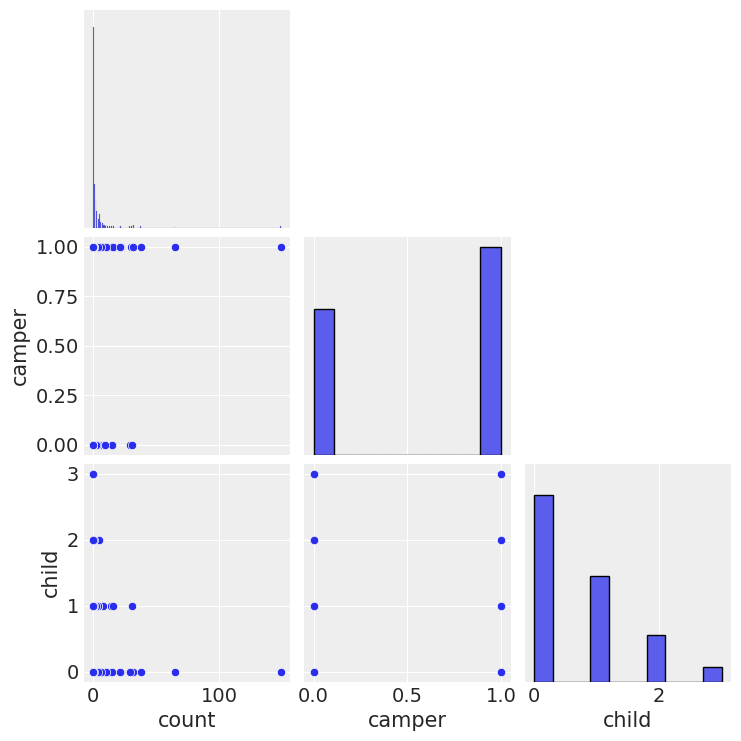

In [ ]:
sns.pairplot(fish.loc[:, ['count', 'camper', 'child']], corner=True)
# plt.savefig('images/ch6/zip.png')

In [ ]:
with pm.Model() as zip_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish['child'] + β[1] * fish['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish['count'])
    # trace_zip_reg = pm.sample(1000, return_inferencedata=True)
    # trace_zip_reg.to_netcdf("data/ch6/zip.nc")
    trace_zip_reg = az.from_netcdf("../../data-pymc/ch6/zip.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, ψ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.


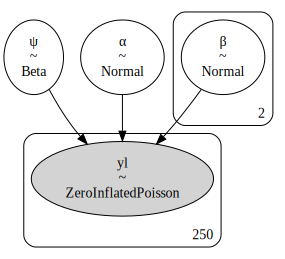

In [ ]:
pm.model_to_graphviz(zip_reg)

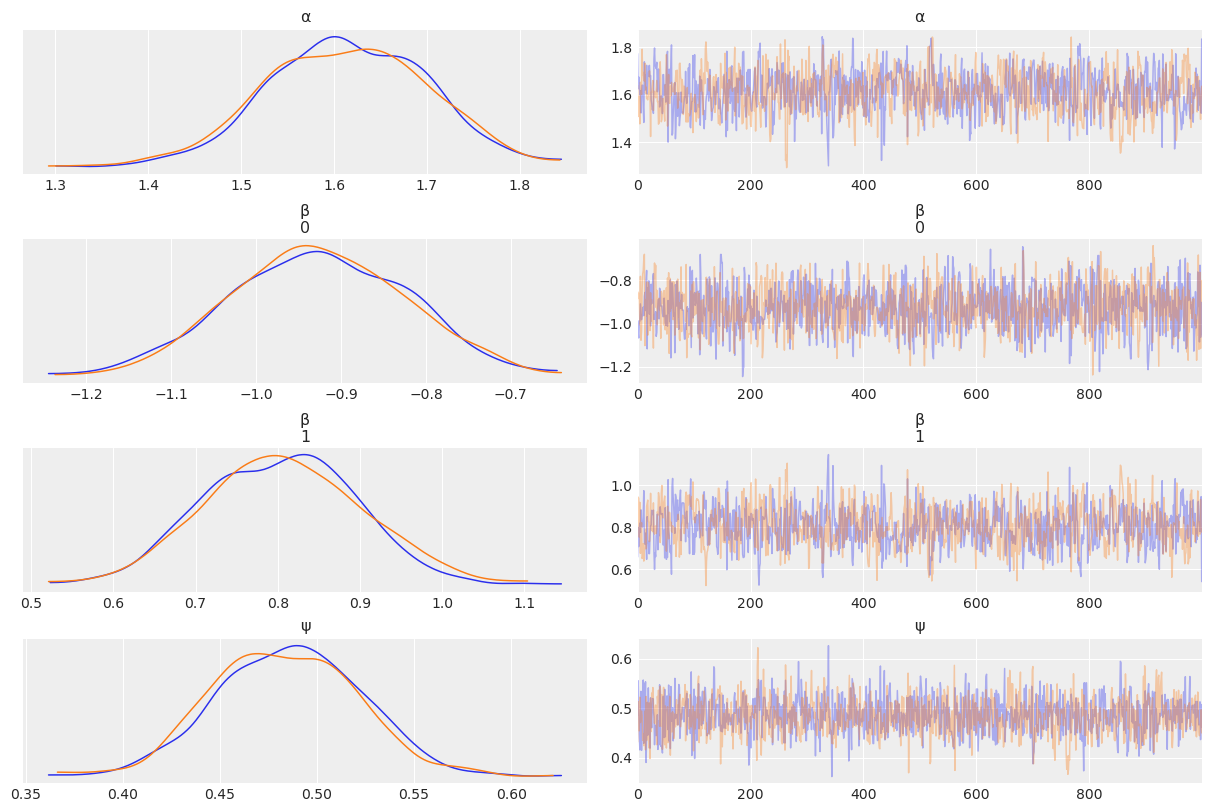

In [ ]:
az.plot_trace(trace_zip_reg, compact=False);

In [ ]:
az.summary(trace_zip_reg)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α     1.614  0.087   1.455    1.775      0.003    0.002     924.0    1115.0   
β[0] -0.926  0.102  -1.118   -0.736      0.003    0.002    1598.0    1393.0   
β[1]  0.805  0.095   0.627    0.977      0.003    0.002     854.0    1117.0   
ψ     0.485  0.037   0.418    0.551      0.001    0.001    1435.0    1079.0   

      r_hat  
α       1.0  
β[0]    1.0  
β[1]    1.0  
ψ       1.0

In [ ]:
az.summary(trace_zip_reg).to_markdown()

'|      |   mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_bulk |   ess_tail |   r_hat |\n|:-----|-------:|------:|---------:|----------:|------------:|----------:|-----------:|-----------:|--------:|\n| α    |  1.614 | 0.087 |    1.455 |     1.775 |       0.003 |     0.002 |        924 |       1115 |       1 |\n| β[0] | -0.926 | 0.102 |   -1.118 |    -0.736 |       0.003 |     0.002 |       1598 |       1393 |       1 |\n| β[1] |  0.805 | 0.095 |    0.627 |     0.977 |       0.003 |     0.002 |        854 |       1117 |       1 |\n| ψ    |  0.485 | 0.037 |    0.418 |     0.551 |       0.001 |     0.001 |       1435 |       1079 |       1 |'

In [ ]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []

α_m = trace_zip_reg.posterior['α'].mean(axis=0)
β_m = trace_zip_reg.posterior['β'].mean(axis=0)

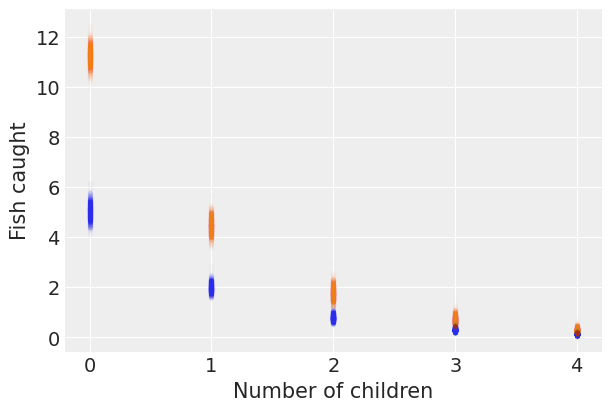

In [ ]:
for n in children:
    without_camper = α_m + β_m[:, 0] * n
    with_camper = without_camper + β_m[:, 1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
ax.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

ax.set(xticks=children, xlabel='Number of children', ylabel='Fish caught')

ax.plot([], 'C0o', label='without camper')
ax.plot([], 'C1o', label='with camper')

# plt.savefig('images/ch6/zip_reg.png')